In [1]:
import numpy as np
import pandas as pd
from simplicialX import *
import networkx as nx

import chess
import chess.pgn
from simplicialX.simplicial import SimplicialComplex

In [6]:
data, moves, mean_legal_moves = create_complex_data(current_game, 'black')

In [37]:
data[21].simplices

[array([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8]]),
 array([[0, 1],
        [0, 4],
        [0, 6],
        [1, 3],
        [1, 4],
        [1, 5],
        [1, 8],
        [2, 3],
        [2, 6],
        [2, 8],
        [3, 4],
        [3, 5],
        [3, 6],
        [3, 8],
        [4, 5],
        [4, 6],
        [4, 8],
        [5, 6],
        [5, 8],
        [6, 8]]),
 array([[0, 4, 6],
        [1, 3, 4],
        [1, 3, 8],
        [1, 4, 8],
        [2, 3, 6],
        [2, 3, 8],
        [2, 6, 8],
        [3, 4, 5],
        [3, 4, 8],
        [3, 6, 8],
        [4, 5, 6],
        [4, 5, 8],
        [4, 6, 8],
        [5, 6, 8]]),
 array([[1, 3, 4, 8],
        [2, 3, 6, 8],
        [4, 5, 6, 8]])]

In [2]:
# строим комплекс для текущей позиции в партии, для текущего цвета

Kn2 = 'b8'
Bi2 = 'c8'
Ro2 = 'a8'

def get_complex(current_game, current_color):
    
    global Kn2
    global Bi2
    global Ro2
    
    white = True
    black = False
    
    if current_color == 'white':
        color = white
    else:
        color = black
        
    board = current_game.board()
    if current_game.move is not None:
        
        Move = current_game.move.uci()
    
        if Move[0] + Move[1] == Kn2:
            Kn2 = Move[2] + Move[3]
        if Move[0] + Move[1] == Bi2:
            Bi2 = Move[2] + Move[3]
        if Move[0] + Move[1] == Ro2:
            Ro2 = Move[2] + Move[3]
        
        if color == 1 and board.piece_type_at(2) == 6 and Move == 'e1c1': #long castle for white
            Ro2 = 'd1'
        if color == 0 and board.piece_type_at(58) == 6 and Move == 'e8c8': #long castle for black
            Ro2 = 'd8'

    c = SimplicialComplex()
    for i in range(9):
       c.add([i])

    R = np.zeros([64,9], dtype=int)
    for i in range(64):
      for attacker in board.attackers(color, i):
        pos = chess.SQUARE_NAMES[attacker]
        j = board.piece_type_at(attacker)-1
        
        if j >= 1 and j <= 3:
            if pos == Kn2 or pos == Bi2 or pos == Ro2:
                j += 5
        R[i, j] = 1

    for i in range(64):
      new_simplex = []
      for j in range(9):
        if R[i].tolist()[j] == 1:
          new_simplex.append(j)
      if new_simplex != []:
        c.add(new_simplex)
      
    return c

# строим набор комплексов для каждой позиции в партии
def create_complex_data(current_game, current_color):
    data = list()
    moves = 0
    mean_legal_moves = 0
    while True:
        data.append(get_complex(current_game, current_color))
        if moves > 15:
            mean_legal_moves += current_game.board().legal_moves.count()
        if current_game.next() is None:
            break
        current_game = current_game.next()
        
        moves += 1
    if mean_legal_moves == 0:
        return (data, moves, mean_legal_moves)
    else:
        return (data, moves, mean_legal_moves / (moves - 15))


# строим признаки комплекса только для одного цвета
def create_features(current_game, current_color):
    data, move, mlm = create_complex_data(current_game, current_color)
    features = np.zeros((move + 1, 18))
    i = 0
    for c in data:
        #print(i)
        features[i] = np.concatenate((c.simplex_adjacency_maximal(), c.simplex_degree_maximal()))
        i += 1
    f = np.mean(features, axis=0)
    f = np.append(f, [move])
    return f

# строим признаки обоих комплексов и для белых и для чёрных
def create_features_both(current_game):
    data1, move, mlm = create_complex_data(current_game, 'white')
    data2, move, mlm = create_complex_data(current_game, 'black')
    features = np.zeros((move + 1, 18))
    features_2 = np.zeros((move + 1, 36))
    
    i = 0
    coef = 1 / len(features)
    
    for c in data1:
        if i <= 15:
            features[i] = coef * np.concatenate((c.simplex_adjacency_maximal(), c.simplex_degree_maximal()))
        else:
            features[i] = np.concatenate((c.simplex_adjacency_maximal(), c.simplex_degree_maximal()))
        i += 1
     
    i = 0

    for c in data2:
        if i <= 15:
            features_2[i] = np.append(features[i], coef * np.concatenate((c.simplex_adjacency_maximal(), c.simplex_degree_maximal())))
        else:
            features_2[i] = np.append(features[i], np.concatenate((c.simplex_adjacency_maximal(), c.simplex_degree_maximal())))
        i += 1
    
    f = np.mean(features_2, axis=0)
    f = np.append(f, [move, mlm])
    return f

def create_data_features(name):
    global Kn2
    global Bi2
    global Ro2
    
    pgn = open(name + '.pgn')
    df = pd.DataFrame(index=np.arange(0), columns=np.arange(25))
    j = 0
    while True:
        print(j, "<-----")
        current_game = chess.pgn.read_game(pgn)
        
        
        if current_game is None:
            break
        current_color = 'black'
        
        Kn2 = 'b8'
        Bi2 = 'c8'
        Ro2 = 'a8'
        
        headers = current_game.headers
        if name in headers.get("White", "?"):
            current_color = 'white'
            Kn2 = 'b1'
            Bi2 = 'c1'
            Ro2 = 'a1'
        print(Kn2, Bi2, Ro2)
        cur_f = create_features(current_game, current_color)
        df = pd.concat([df, pd.DataFrame(cur_f).T])
        j += 1
    return df
        

In [28]:


kas_df = pd.read_csv('KasparovDif.csv')
car_df = pd.read_csv('CarlsenDif.csv')


In [30]:
kas_df['Name'] = 'Kasparov'
car_df['Name'] = 'Carlsen'

In [32]:
car_df

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,Name
0,0,2.851064,4.319149,1.659574,2.595745,4.893617,4.127660,3.106383,1.765957,2.255319,...,2.829787,0.893617,1.595745,3.212766,2.553191,1.638298,0.936170,1.340426,46.0,Carlsen
1,0,3.352113,4.239437,2.323944,3.450704,3.436620,3.549296,3.957746,2.873239,2.366197,...,2.971831,1.323944,2.380282,1.971831,2.070423,2.436620,1.732394,1.605634,70.0,Carlsen
2,0,3.821429,3.392857,1.410714,2.000000,5.196429,3.750000,0.839286,4.035714,2.375000,...,1.910714,0.660714,1.178571,3.642857,2.464286,0.392857,2.767857,1.839286,55.0,Carlsen
3,0,2.533333,1.383333,1.466667,2.366667,3.883333,2.816667,2.416667,2.550000,1.283333,...,0.816667,0.850000,1.866667,2.683333,1.833333,1.483333,1.516667,0.983333,59.0,Carlsen
4,0,2.622222,2.822222,3.133333,1.377778,5.377778,4.288889,1.822222,2.044444,2.022222,...,1.822222,1.911111,1.133333,3.688889,2.711111,0.911111,1.044444,1.355556,44.0,Carlsen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4309,0,2.588235,0.450980,1.045752,1.418301,2.052288,2.019608,1.039216,0.653595,1.986928,...,0.241830,0.686275,0.921569,1.333333,1.333333,0.620915,0.320261,1.294118,152.0,Carlsen
4310,0,2.382353,1.147059,0.245098,1.617647,4.225490,3.049020,1.303922,2.490196,0.990196,...,0.637255,0.117647,1.186275,3.117647,2.039216,0.647059,1.774510,0.833333,101.0,Carlsen
4311,0,2.716535,0.795276,2.519685,1.984252,4.440945,2.535433,3.480315,0.818898,1.937008,...,0.519685,1.637795,1.322835,3.251969,1.842520,2.346457,0.417323,1.385827,126.0,Carlsen
4312,0,2.323077,1.484615,1.092308,1.253846,2.500000,1.784615,0.761538,1.607692,1.623077,...,1.000000,0.769231,0.984615,1.900000,1.292308,0.453846,1.061538,1.369231,129.0,Carlsen


In [33]:
data = pd.concat([kas_df, car_df])
data = data.drop(['Unnamed: 0'], axis=1)
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,Name
0,3.180723,1.156627,2.746988,3.048193,5.301205,4.060241,3.469880,3.096386,2.204819,2.156627,0.578313,1.168675,1.963855,3.144578,2.518072,1.710843,1.843373,1.301205,82.0,Kasparov
1,2.092105,1.447368,1.447368,1.394737,1.473684,2.526316,1.421053,0.842105,1.644737,1.513158,0.723684,0.750000,1.078947,0.947368,1.750000,0.907895,0.460526,1.250000,75.0,Kasparov
2,3.911765,1.794118,2.764706,1.970588,6.117647,4.588235,3.411765,3.264706,2.235294,3.176471,0.911765,1.441176,1.735294,4.264706,2.794118,1.823529,1.941176,1.970588,33.0,Kasparov
3,3.803922,4.196078,3.529412,3.215686,6.450980,4.098039,3.156863,2.176471,3.058824,3.098039,2.529412,1.725490,2.098039,4.078431,2.392157,2.019608,1.235294,1.784314,50.0,Kasparov
4,2.630952,4.416667,3.476190,2.178571,4.630952,4.464286,4.047619,1.309524,4.345238,2.297619,2.523810,1.761905,1.369048,2.571429,2.142857,2.464286,0.583333,2.666667,83.0,Kasparov
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4309,2.588235,0.450980,1.045752,1.418301,2.052288,2.019608,1.039216,0.653595,1.986928,1.986928,0.241830,0.686275,0.921569,1.333333,1.333333,0.620915,0.320261,1.294118,152.0,Carlsen
4310,2.382353,1.147059,0.245098,1.617647,4.225490,3.049020,1.303922,2.490196,0.990196,1.980392,0.637255,0.117647,1.186275,3.117647,2.039216,0.647059,1.774510,0.833333,101.0,Carlsen
4311,2.716535,0.795276,2.519685,1.984252,4.440945,2.535433,3.480315,0.818898,1.937008,2.102362,0.519685,1.637795,1.322835,3.251969,1.842520,2.346457,0.417323,1.385827,126.0,Carlsen
4312,2.323077,1.484615,1.092308,1.253846,2.500000,1.784615,0.761538,1.607692,1.623077,1.923077,1.000000,0.769231,0.984615,1.900000,1.292308,0.453846,1.061538,1.369231,129.0,Carlsen


In [34]:
X = data.iloc[:,:-1].values
y = data['Name']

In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.ensemble import GradientBoostingClassifier

In [42]:
from sklearn import model_selection

In [43]:
import matplotlib.pyplot as plt

In [44]:
classifiers = []

classifiers.append(('SGD', SGDClassifier(max_iter = 1200, tol = 1e-4)))
classifiers.append(('SVL', SVC(kernel = 'rbf', gamma=0.05, probability = True)))
classifiers.append(('RF', RandomForestClassifier(n_estimators=44, max_depth=13, random_state=3)))
classifiers.append(('AB', AdaBoostClassifier()))
classifiers.append(('DT', DecisionTreeClassifier()))
classifiers.append(('LR', LogisticRegression(solver = 'lbfgs', max_iter = 500, multi_class = 'auto')))
classifiers.append(('NB', GaussianNB()))
classifiers.append(('SVR', SVC(gamma = 2, C = 1.0)))
classifiers.append(('MLP', MLPClassifier(alpha = 0.01, max_iter = 200, solver = 'lbfgs', tol = 0.001)))
classifiers.append(('KNN', KNeighborsClassifier(3)))
classifiers.append(('QDA', QuadraticDiscriminantAnalysis()))
classifiers.append(('LDA', LinearDiscriminantAnalysis()))

In [45]:
results = []
names = []
for name, classifier in classifiers:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    results.append(accuracy_score(y_pred, y_test))
    names.append(name)


C:\Users\ilyas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [48]:
import seaborn as sns

In [49]:
crdata = pd.DataFrame(data={'Names': names, 'Score': results})
crdata

,Names,Score
0,SGD,0.653995
1,SVL,0.678821
2,RF,0.674942
3,AB,0.682700
4,DT,0.584950
5,LR,0.691234
6,NB,0.618309
7,SVR,0.674942
8,MLP,0.704422
9,KNN,0.598138


<Axes: >

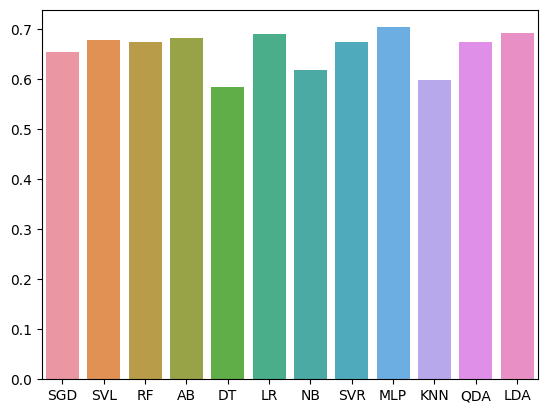

In [50]:
sns.barplot( x=names, y=results)